In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal

np.random.seed(42)

In [2]:
data_path = "./dataset/"
data_file = "3D_data_points"
data_file_extension = ".txt"

X = np.loadtxt(fname=data_path+data_file+data_file_extension, delimiter=',', dtype='float64')

print(X.shape)

(2000, 3)


In [3]:
class PCA:
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.pcs = None
        self.mean = None

    def fit_transform(self, X):

        if(X.shape[1] < 3):
            return X
        
        # Center data
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean

        # Perform SVD
        U, S, Vt = np.linalg.svd(X_centered)

        U_k = U[:, :self.n_components]
        S_k = np.diag(S[:self.n_components])
        Vt_k = Vt[:self.n_components, :]

        # Save components and return
        self.pcs = np.dot(U_k, S_k)
        X_transformed = np.dot(X_centered, Vt_k.T)

        return X_transformed

In [4]:
pca = PCA(n_components=2)
X_transformed = pca.fit_transform(X)
X_transformed.shape

(2000, 2)

In [5]:
from sklearn.decomposition import PCA as skPCA

sk_pca = skPCA(n_components=2)
sk_transformed_data = sk_pca.fit_transform(X)

sk_transformed_data.shape

(2000, 2)

In [6]:
print(X_transformed[0])
print(sk_transformed_data[0])

[-0.22078164  0.86240768]
[ 0.22078164 -0.86240768]


In [7]:
# write a function to plot the 2d data after PCA
def plot_2d_data(X, title):
    plt.scatter(X[:, 0], X[:, 1])
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(title)
    plt.show()

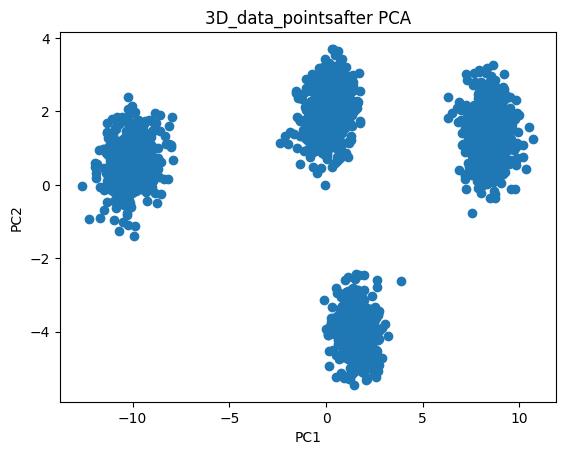

In [8]:
plot_2d_data(X_transformed, title=str(data_file+"after PCA"))

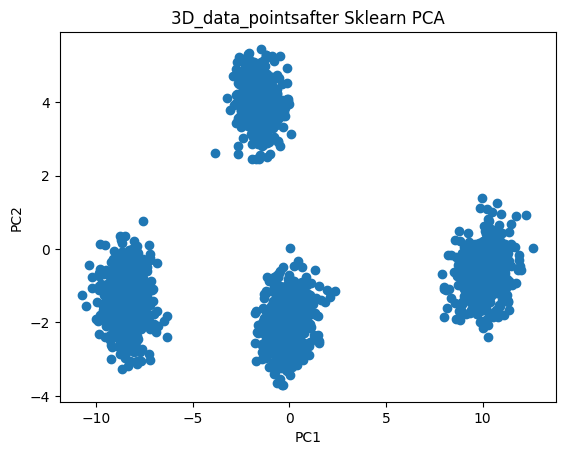

In [69]:
# plot_2d_data(sk_transformed_data, str(data_file+"after Sklearn PCA"))

In [12]:
# guassian mixture model
class GMM:
    def __init__(self, n_components=2, max_iter=1000):
        self.n_components = n_components
        self.max_iter = max_iter
        self.means = None
        self.covs = None
        self.weights = None
        self.log_likelihoods = []

    def init_params(self, X):
        # Initialize parameters
        self.means = np.random.rand(self.n_components, X.shape[1])
        self.covs = np.array([np.eye(X.shape[1]) for _ in range(self.n_components)])
        self.weights = np.random.rand(self.n_components)
        self.weights = self.weights / np.sum(self.weights)

    def fit(self, X):
        # Initialize parameters
        self.init_params(X)

        # Iterate until convergence
        for i in range(self.max_iter):
            # self.plot_contour()
            resp = self._e_step(X)
            self._m_step(X, resp)
            if (i > 0 and self._check_log_likelihood_convergence()):
                break
        
        return self.log_likelihoods[-1]
    
    def calculate_log_likelihood(self, resp):
        # Evaluate log likelihood
        log_likelihood = np.sum(np.log(np.sum(resp, axis=1)))
        self.log_likelihoods.append(log_likelihood)


    def _e_step(self, X):
        # Calculate responsibilities
        resp = np.zeros((X.shape[0], self.n_components))
        for k in range(self.n_components):
            resp[:, k] = self.weights[k] * self._gaussian(X, self.means[k], self.covs[k])
        self.calculate_log_likelihood(resp)
        resp = resp / np.sum(resp, axis=1).reshape(-1, 1)
        return resp

    def _m_step(self, X, resp):
        # Calculate parameters
        for k in range(self.n_components):
            self.means[k] = np.sum(resp[:, k].reshape(-1, 1) * X, axis=0) / np.sum(resp[:, k])
            self.covs[k] = np.dot((resp[:, k].reshape(-1, 1) * (X - self.means[k])).T, (X - self.means[k])) / np.sum(resp[:, k])
            self.weights[k] = np.sum(resp[:, k]) / X.shape[0]
    
    def _gaussian(self, X, mean, cov):
        # Calculate Gaussian distribution
        # if conv is singular, add small value to diagonal
        if (np.linalg.det(cov) < 1e-9):
            cov += np.eye(cov.shape[0]) * 1e-8
        X_centered = X - mean
        dim = X.shape[1]
        pdf = 1.0 / (np.sqrt((2 * np.pi)**dim * np.linalg.det(cov))) * np.exp(-0.5 * np.sum(np.dot(X_centered, np.linalg.inv(cov)) * X_centered, axis=1))  
        return pdf

    def _check_log_likelihood_convergence(self):
        # Check if converged
        if (abs(self.log_likelihoods[-1] - self.log_likelihoods[-2]) < 0.0001):
            return True
        return False

    def predict(self, X):
        # Predict cluster labels
        resp = self._e_step(X)
        return np.argmax(resp, axis=1)

    def plot_clusters(self, X, title):
        # Plot clusters using seaborn
        labels = self.predict(X)
        df = pd.DataFrame(X, columns=['PC1', 'PC2'])
        df['Clusters'] = labels+1
        custom_palette = sns.color_palette("bright", self.n_components)
        sns.scatterplot(x='PC1', y='PC2', hue='Clusters', palette=custom_palette, data=df)
        plt.title(title)
        plt.show()
    
    # def plot_contour(self):
    #     # Plot contour of each cluster
    #     n_components = self.n_components
    #     mean = self.means
    #     cov = self.covs

    #     colors = ['blue', 'green', 'red', 'black', 'olive', 'yellow', 'violet', 'white']

    #     plt.ion()
    #     plt.scatter(X[:, 0], X[:, 1], s=10, edgecolor='k', alpha=0.5, marker='o')
        
    #     #Create grid of points
    #     x_grid, y_grid = np.mgrid[np.min(X[:, 0]):np.max(X[:, 0]):.01, np.min(X[:, 1]):np.max(X[:, 1]):.01]
    #     positions = np.dstack((x_grid, y_grid))

        
    #     for k in range(n_components):
    #         rv = multivariate_normal(mean[k], cov[k], allow_singular=True).pdf(positions)
    #         plt.contour(x_grid, y_grid, rv, extend="min", colors=colors[k%8], alpha=0.8, linewidths=2)
    #     plt.title("GMM-EM: " + str(n_components) + " Gaussians", size=15)
        
    #     plt.pause(0.05)
    #     plt.clf()
    #     plt.show()
    #     plt.ioff()


In [13]:
# write a function to plot log likelihood vs k
def plot_log_likelihood(log_likelihoods, k_range, title):
    plt.plot(k_range, log_likelihoods)
    plt.xlabel('Number of clusters, k')
    plt.ylabel('Log likelihood')
    plt.title(title)
    plt.grid()
    plt.show()

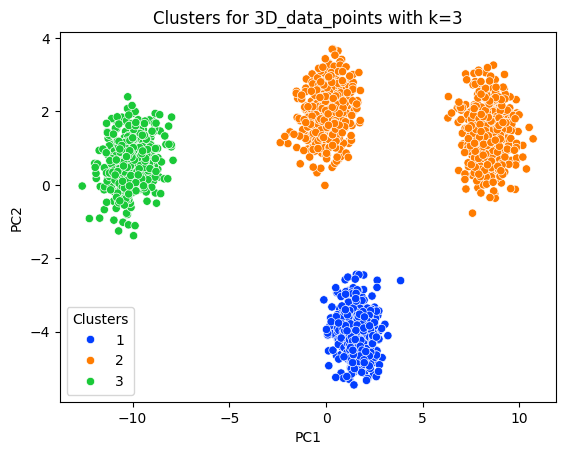

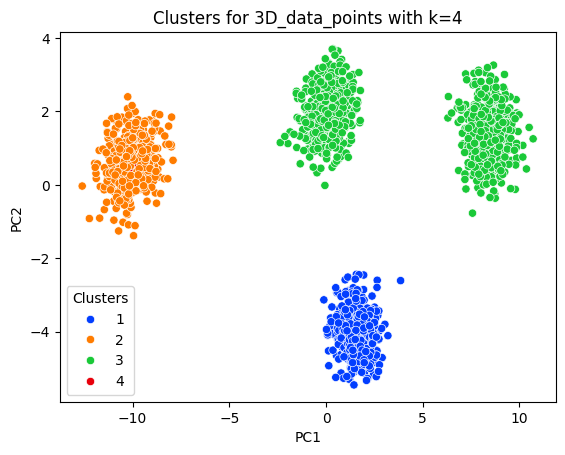

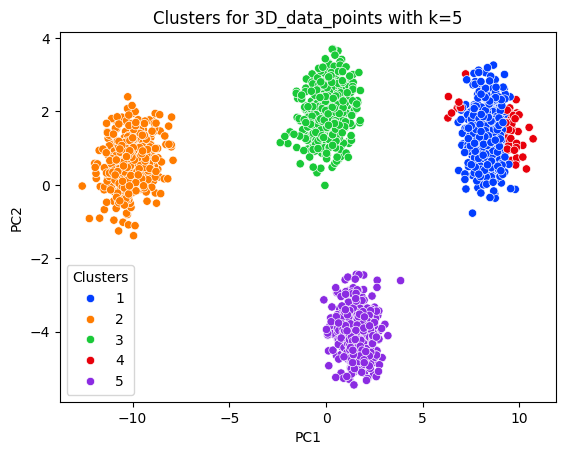

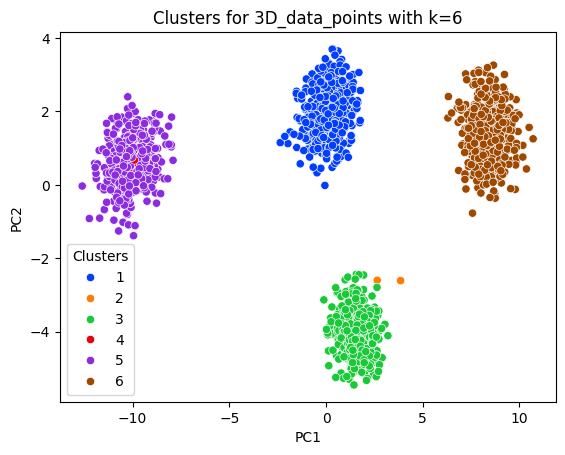

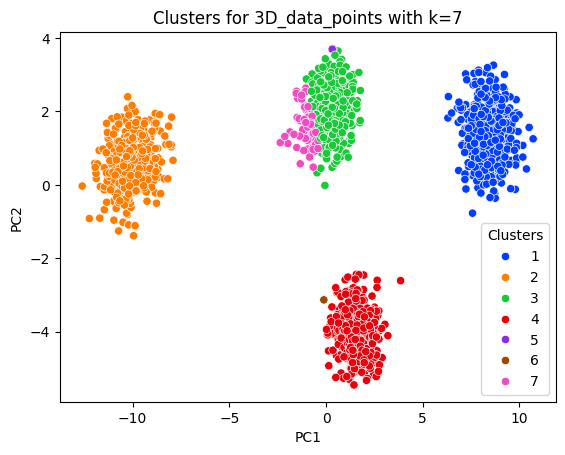

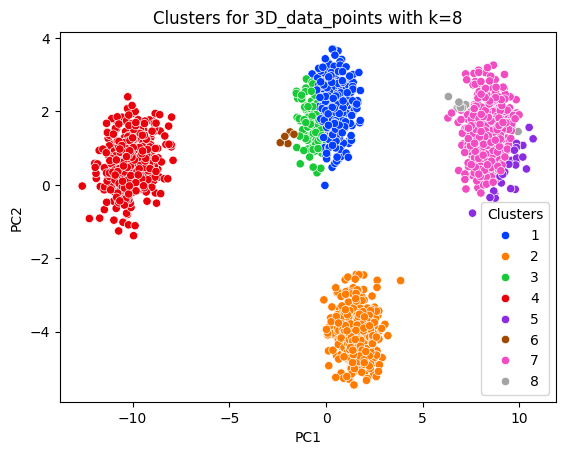

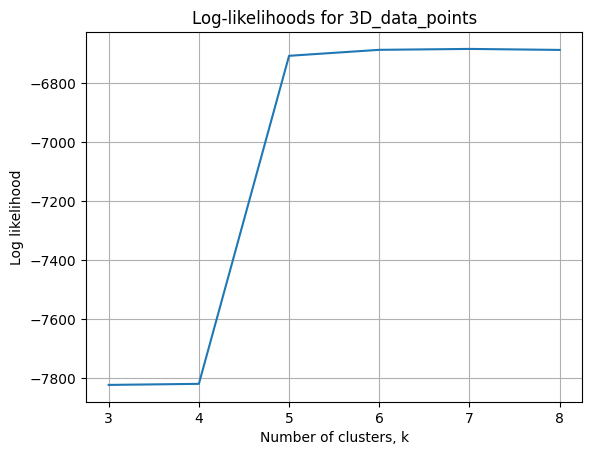

In [14]:
log_likelihoods = []
k_range = range(3, 9)
for k in k_range:
    gmm = GMM(n_components=k)
    log_likelihood = gmm.fit(X_transformed)
    log_likelihoods.append(log_likelihood)
    gmm.plot_clusters(X_transformed, title=str("Clusters for " + data_file + " with k=" + str(k)))

plot_log_likelihood(log_likelihoods, k_range, title=str("Log-likelihoods for " + data_file))